## Work distributions for a harmonic oscillator in the canonical ensemble

In [1]:
using DifferentialEquations
import Distributions.Normal
import Distributions.Logistic

In [2]:
using PyPlot

In [3]:
const b = 1.0/1.5;
const QNH = 1.0;
const tauHH = 1.0;
const QLog = 1.0;
Ns = 10^5;

### Nosé-Hoover

$$ f(\zeta) = \sqrt{\frac{\beta}{2\pi Q}} \exp\left(-\frac{\beta \zeta^2}{2 Q} \right) $$

\begin{eqnarray}
\dot{q} &=& p \\
\dot{p} &=& -\left(1 + \frac{t}{t_s} \right)^2 q - \frac{\zeta p}{Q} \\
\dot{\zeta} &=& p^2 - \frac{1}{\beta} \\
\dot{\nu} &=& \frac{\zeta}{Q}
\end{eqnarray}

In [14]:
function NoseHoover(t, u, du; ts=1., beta = b, Q = QNH) 
    du[1] = u[2]
    du[2] = -(1+t/ts)^2*u[1] - u[3]*u[2]/Q 
    #du[2] = -(1)^2*u[1] - u[3]*u[2]/Q  ##Isothermal dynamics (omega = 1)
    du[3] = u[2]^2 - 1/beta
    du[4] = u[3]/Q
end 

NoseHoover (generic function with 1 method)

In [15]:
function rhoNH(z; beta = b, Q = QNH)
    return (beta/(2*pi*Q))^(1/2)*exp(-beta*z^2/(2*Q))
end

rhoNH (generic function with 1 method)

In [16]:
function heat(rho::Function, y0::Float64, yf::Float64, vf; beta = b)
    psif = -1/b*log(rho(yf))
    psi0 = -1/b*log(rho(y0))
    q = -psif + psi0 - vf/b
end

heat (generic function with 1 method)

In [17]:
function workNH()
    q0,p0 = rand(Normal(0.0, 1./sqrt(b)),2)
    zeta0 = rand(Normal(0.0, QNH/sqrt(b)))
    #q0,p0,zeta0=x,y,z1
    nu0 = 0.0
    u0NH = [q0,p0,zeta0,nu0]
    I0 = q0^2/2. + p0^2./2. + zeta0^2./(2*QNH)
    tspan = (0.0,1.0)
    probNH = ODEProblem(NoseHoover,u0NH,tspan)
    solNH = solve(probNH,DP8());
    NHsol = solNH.u;
    qf, pf, zetaf, nuf = NHsol[end];
    If = 4.*qf^2/2. + pf^2./2. + zetaf^2./(2*QNH) 
    return If - I0 + 1./b*nuf
end

workNH (generic function with 1 method)

In [18]:
function qNH()
    q0,p0 = rand(Normal(0.0, 1./sqrt(b)),2)
    zeta0 = rand(Normal(0.0, QNH/sqrt(b)))
    #q0,p0,zeta0=x,y,z1
    nu0 = 0.0
    u0NH = [q0,p0,zeta0,nu0]
    tspan = (0.0,1.0)
    probNH = ODEProblem(NoseHoover,u0NH,tspan)
    solNH = solve(probNH,DP8());
    NHsol = solNH.u;
    qf, pf, zetaf, nuf = NHsol[end];
    return heat(rhoNH, zeta0, zetaf, nuf)
end

qNH (generic function with 1 method)

In [19]:
qNH()

0.4479534763198726

In [20]:
workNH()

1.5806800160138137

In [21]:
#Ns = 10^5
w_NH = zeros(Ns);
for i in 1:Ns
    w_NH[i] = workNH()
end
deltaF_NH = -1/b.*log(mean(exp(-b*w_NH)))  , mean(w_NH) ##Theoretical ΔF = 1.0397,

(1.0388683840674,1.8582043017162526)

In [22]:
heat_NH = zeros(Ns);
for i in 1:Ns
    heat_NH[i] = qNH()
end

mean(heat_NH), std(heat_NH)

(-0.45208688074118153,2.3882556971044124)

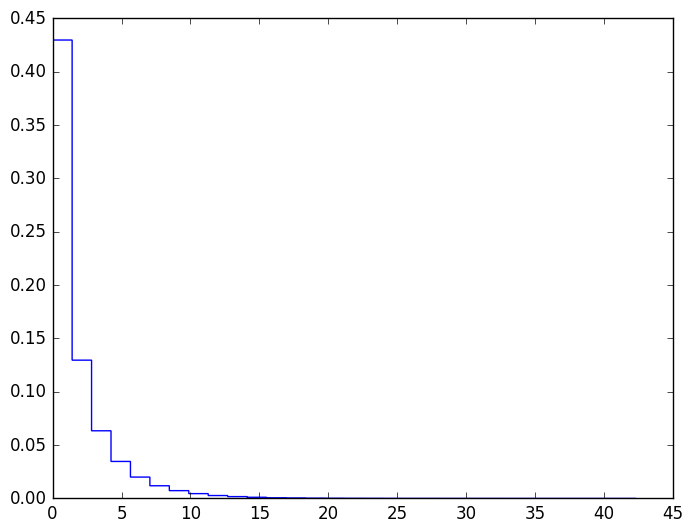

([0.429766,0.129646,0.0634321,0.0346912,0.0200302,0.0118871,0.00731669,0.00452438,0.00272781,0.00172357  …  1.13393e-5,1.48828e-5,5.66965e-6,2.83483e-6,2.12612e-6,0.0,1.41741e-6,7.08707e-7,7.08707e-7,1.41741e-6],[2.3114e-6,1.41102,2.82204,4.23307,5.64409,7.05511,8.46613,9.87715,11.2882,12.6992  …  29.6314,31.0425,32.4535,33.8645,35.2755,36.6866,38.0976,39.5086,40.9196,42.3306],Any[PyObject <matplotlib.patches.Polygon object at 0x7f741363eb50>])

In [23]:
plt[:hist](w_NH,bins = 30, normed = true, histtype="step")
#histogram(w_NH,nbins = 30, normed = true)

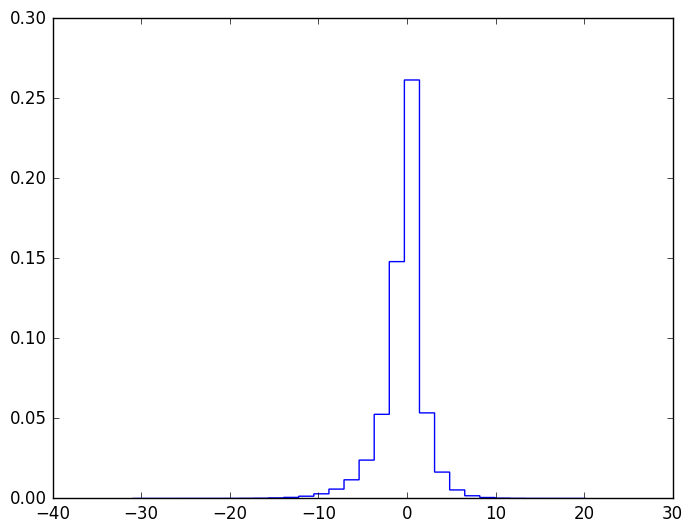

([1.17386e-6,0.0,1.17386e-6,4.69543e-6,7.04314e-6,1.46732e-5,2.52379e-5,6.92575e-5,0.000137928,0.000329267  …  0.0164733,0.00532051,0.00167392,0.000588102,0.000182535,5.98667e-5,1.23255e-5,2.34771e-6,1.17386e-6,5.86928e-7],[-30.9597,-29.2559,-27.5521,-25.8484,-24.1446,-22.4408,-20.737,-19.0332,-17.3294,-15.6257  …  4.81978,6.52356,8.22735,9.93113,11.6349,13.3387,15.0425,16.7463,18.4501,20.1538],Any[PyObject <matplotlib.patches.Polygon object at 0x7f74131239d0>])

In [24]:
plt[:hist](heat_NH, bins = 30, normed = true, histtype="step")

In [25]:
#deltaiNH = [NHsol[i][2]^2/2.  + NHsol[i][1]^2/2. + NHsol[i][3]^2/(2.*QNH)  + 1./b*NHsol[i][4] for i in 1:length(solNH.u)] - I0;

### Logistic thermostat

\begin{eqnarray}
\dot{q} &=& p \\
\dot{p} &=& -\left(1 + \frac{t}{t_s} \right)^2 q - \frac{\tanh\left(\frac{\zeta}{2Q} \right)p}{\beta Q} \\
\dot{\zeta} &=& p^2 - \frac{1}{\beta} \\
\dot{\nu} &=& \frac{\tanh\left(\frac{\zeta}{2Q} \right)}{\beta Q}
\end{eqnarray}

In [26]:
function LogisticTh(t, u, du; ts=1., beta = b, Q = QLog) 
    du[1] = u[2]
    du[2] = -(1+t/ts)^2*u[1] - tanh(u[3]/(2*Q))*u[2]/(beta*Q)
    #du[2] = -(1)^2*u[1] - u[3]*u[2]/Q  ##Isothermal dynamics (omega = 1)
    du[3] = u[2]^2 - 1/beta
    du[4] = tanh(u[3]/(2*Q))/(beta*Q)
end 

LogisticTh (generic function with 1 method)

In [27]:
function rholog(z; beta = b, Q = QLog)
    return exp(z/QLog)/(QLog*(1+exp(z/QLog))^2.)
end

rholog (generic function with 1 method)

In [28]:
function heatlog()
    q0,p0 = rand(Normal(0.0, 1./sqrt(b)),2)
    z0 = rand(Logistic(0.0,QLog))
    #q0,p0,z0=x,y,z1
    nu0 = 0.0
    u0 = [q0,p0,z0,nu0]
    tspan = (0.0,1.0)
    problog = ODEProblem(LogisticTh,u0,tspan)
    sol = solve(problog, DP8());
    Lsol = sol.u;
    qf, pf, zf, nuf = Lsol[end]
    return heat(rholog, z0, zf, nuf)
end    


heatlog (generic function with 1 method)

In [29]:
function worklog()
    q0,p0 = rand(Normal(0.0, 1./sqrt(b)),2)
    z0 = rand(Logistic(0.0,QLog))
    #q0,p0,z0=x,y,z1
    nu0 = 0.0
    u0 = [q0,p0,z0,nu0]
    I0 = q0^2/2. + p0^2./2. - log(exp(z0/QLog)/(QLog*(1+exp(z0/QLog))^2.))/b
    tspan = (0.0,1.0)
    problog = ODEProblem(LogisticTh,u0,tspan)
    sol = solve(problog, DP8());
    Lsol = sol.u;
    qf, pf, zf, nuf = Lsol[end];
    If = 4.*qf^2/2. + pf^2./2. - log(exp(zf/QLog)/(QLog*(1+exp(zf/QLog))^2.))/b
    return If - I0 + 1./b*nuf
end

worklog (generic function with 1 method)

In [30]:
heatlog()

0.276652219912886

In [31]:
worklog()

1.6438315276770348

In [32]:
#Ns = 10^4
h_log = zeros(Ns);
for i in 1:Ns
    h_log[i] = heatlog()
end

mean(h_log), std(h_log)

(-0.287828193519942,1.9169226446465604)

In [54]:
mean(h_log), mean(heat_NH)

(-0.287828193519942,-0.45208688074118153)

In [56]:
mean(exp(-b*h_log)),mean(exp(-b*heat_NH))

(25.422321603785687,1706.6314027627602)

In [33]:
#Ns = 10^4
w_log = zeros(Ns);
for i in 1:Ns
    w_log[i] = worklog()
end

In [34]:
deltaF_log = -1/b*log(mean(exp(-b*w_log)))  ##Theoretical = 1.0397

1.0404005166213595

In [53]:
mean(w_log),std(w_log)

(1.8580359825598953,2.4011455657654666)

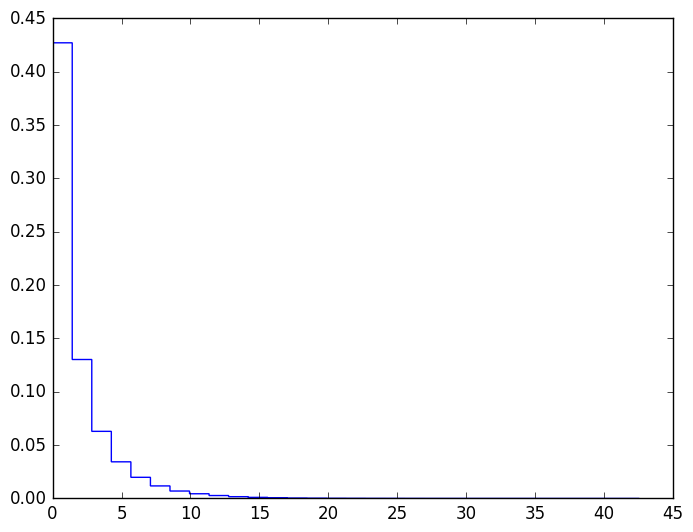

([0.42716,0.130259,0.0629074,0.0343375,0.0198119,0.0117468,0.00695236,0.00439271,0.00272315,0.00164982  …  1.33902e-5,7.75225e-6,7.75225e-6,2.11425e-6,3.52375e-6,7.0475e-7,1.4095e-6,0.0,0.0,7.0475e-7],[3.52697e-7,1.41894,2.83789,4.25683,5.67577,7.09472,8.51366,9.9326,11.3515,12.7705  …  29.7978,31.2167,32.6357,34.0546,35.4736,36.8925,38.3115,39.7304,41.1493,42.5683],Any[PyObject <matplotlib.patches.Polygon object at 0x7f7410bd6490>])

In [36]:
plt[:hist](w_log,bins = 30, normed = true, histtype="step")
#histogram(w_log,nbins = 30, normed = true)

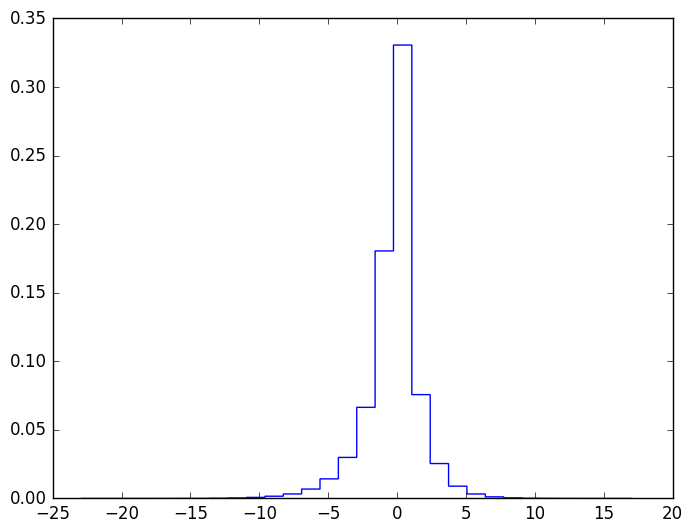

([7.50157e-7,1.50031e-6,6.00126e-6,6.00126e-6,2.02542e-5,4.05085e-5,6.22631e-5,0.000171036,0.000384081,0.000775663  …  0.00895538,0.00326018,0.00116199,0.000442593,0.000153032,7.05148e-5,2.77558e-5,1.12524e-5,2.25047e-6,1.50031e-6],[-22.9271,-21.594,-20.261,-18.9279,-17.5949,-16.2618,-14.9287,-13.5957,-12.2626,-10.9296  …  5.06705,6.40011,7.73316,9.06622,10.3993,11.7323,13.0654,14.3984,15.7315,17.0645],Any[PyObject <matplotlib.patches.Polygon object at 0x7f7410b21610>])

In [37]:
plt[:hist](h_log,bins = 30, normed = true, histtype="step")

## Comparison

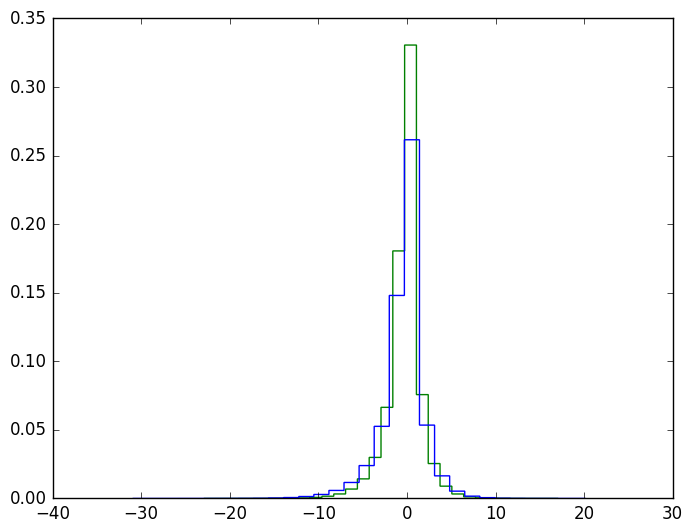

([1.17386e-6,0.0,1.17386e-6,4.69543e-6,7.04314e-6,1.46732e-5,2.52379e-5,6.92575e-5,0.000137928,0.000329267  …  0.0164733,0.00532051,0.00167392,0.000588102,0.000182535,5.98667e-5,1.23255e-5,2.34771e-6,1.17386e-6,5.86928e-7],[-30.9597,-29.2559,-27.5521,-25.8484,-24.1446,-22.4408,-20.737,-19.0332,-17.3294,-15.6257  …  4.81978,6.52356,8.22735,9.93113,11.6349,13.3387,15.0425,16.7463,18.4501,20.1538],Any[PyObject <matplotlib.patches.Polygon object at 0x7f74105df310>])

In [49]:
plt[:hist](h_log,bins = 30, normed = true, histtype="step", color="g")
plt[:hist](heat_NH, bins = 30, normed = true, histtype="step", color="b")

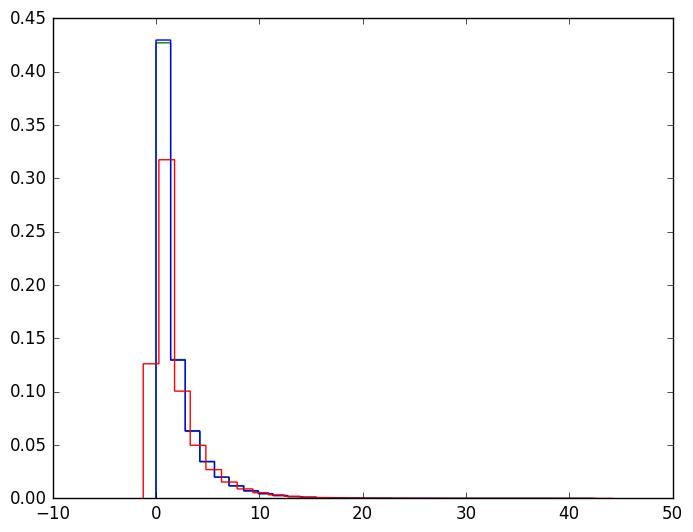

([0.126248,0.317528,0.100608,0.0498431,0.027029,0.0154071,0.00894037,0.00543086,0.00333664,0.00202165  …  1.31961e-5,8.57748e-6,3.95884e-6,2.63922e-6,1.97942e-6,1.97942e-6,0.0,0.0,0.0,6.59806e-7],[-1.23697,0.278622,1.79422,3.30982,4.82541,6.34101,7.8566,9.3722,10.8878,12.4034  …  30.5906,32.1062,33.6217,35.1373,36.6529,38.1685,39.6841,41.1997,42.7153,44.2309],Any[PyObject <matplotlib.patches.Polygon object at 0x7f741093f790>])

In [39]:
plt[:hist](w_log,bins = 30, normed = true, histtype="step", color="g")
plt[:hist](w_NH,bins = 30, normed = true, histtype="step", color = "blue")
plt[:hist](w_HH,bins = 30, normed = true, histtype="step", color = "red")

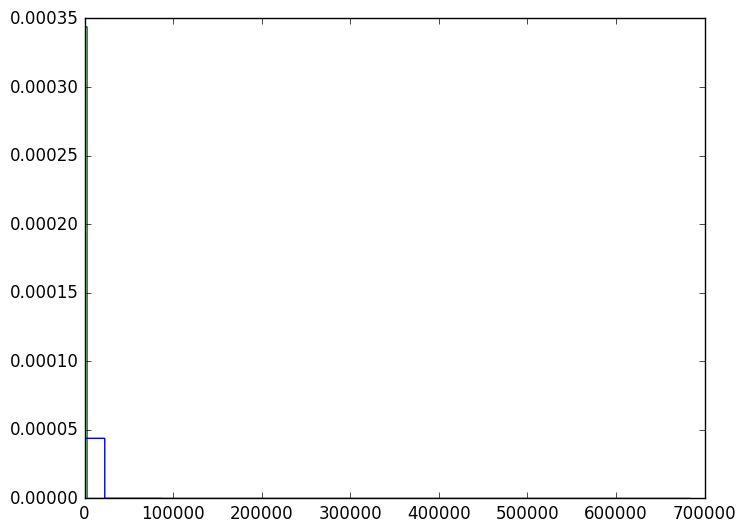

([4.38512e-5,8.77031e-11,8.77031e-11,0.0,0.0,0.0,0.0,4.38515e-11,0.0,4.38515e-11  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.38515e-11],[1.08703e-9,22804.2,45608.4,68412.7,91216.9,1.14021e5,1.36825e5,1.5963e5,1.82434e5,205238.0  …  4.78889e5,5.01693e5,5.24497e5,5.47301e5,5.70106e5,5.9291e5,615714.0,6.38518e5,6.61322e5,6.84127e5],Any[PyObject <matplotlib.patches.Polygon object at 0x7f7410210ed0>])

In [60]:
plt[:hist](exp(b*h_log), bins = 30, normed = true, histtype="step", color = "g")
plt[:hist](exp(b*heat_NH),bins = 30, normed = true, histtype="step", color = "blue")

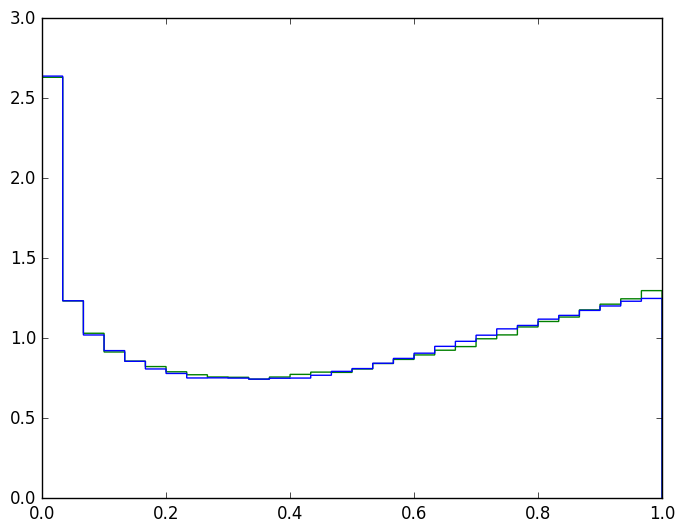

([2.63961,1.23549,1.02165,0.923911,0.857161,0.809281,0.781201,0.753001,0.753781,0.752101  …  0.982052,1.02033,1.05993,1.08126,1.12062,1.14411,1.17522,1.20288,1.23252,1.25001],[5.54659e-13,0.0333333,0.0666666,0.0999998,0.133333,0.166666,0.2,0.233333,0.266666,0.3  …  0.699999,0.733332,0.766665,0.799999,0.833332,0.866665,0.899999,0.933332,0.966665,0.999998],Any[PyObject <matplotlib.patches.Polygon object at 0x7f7410457dd0>])

In [57]:
plt[:hist](exp(-b*w_log), bins = 30, normed = true, histtype="step", color = "g")
plt[:hist](exp(-b*w_NH),bins = 30, normed = true, histtype="step", color = "blue")
#plt[:hist](exp(-b*w_HH),bins = 30, normed = true, histtype="step", color = "red")

In [41]:
maximum(exp(-b*w_log)), minimum(exp(-b*w_log))

(0.9999997648687542,4.733878103685822e-13)

In [42]:
maximum(exp(-b*w_HH)), minimum(exp(-b*w_HH))

(2.281081649536335,1.5625582054629125e-13)

In [43]:
mean(exp(-b*w_log)), std(exp(-b*w_log))

(0.49977346940446843,0.31895114124759444)

In [44]:
mean(exp(-b*w_HH)), std(exp(-b*w_HH))

(0.5007729272706429,0.31806367074999525)

In [45]:
mean(exp(-b*w_NH)), std(exp(-b*w_NH))

(0.500284209668712,0.3183561804955111)